In [5]:
import numpy as np

import matplotlib.pyplot as plt
plt.jet()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Figure size 640x480 with 0 Axes>

### Optical Testing configuration

In [ ]:
omega_arcsec = 0.1
arc_length_arcsec = 50
time_interval_s = 50

### Numerical Testing configuration

In [51]:
#for testing; easier visualization.
omega_arcsec = 0.1 *3600 *10 #turn it into 1 deg/s
arc_length_arcsec = 50 *3600 /50*360 #turn it into 360 deg
time_interval_s = 20

In [52]:
total_time_s = arc_length_arcsec/omega_arcsec
total_time_m = total_time_s/60.
n_time = int(total_time_s/time_interval_s)
print('This will take %.1f minutes = %.1f seconds'%(total_time_m, total_time_s))
print('Number of samples in time = %d'%n_time)

omega_rad = omega_arcsec/3600./180*np.pi
tt = np.linspace(0,time_interval_s*(n_time-1), n_time) #time vector
theta_m1s7 = omega_rad*tt
v_mag = r_S1_center_in_S7*omega_rad

This will take 6.0 minutes = 360.0 seconds
Number of samples in time = 18


In [89]:
p_m1s7 = np.zeros((n_time, 6))
v_m1s7 = np.zeros((n_time, 6))
p_m1b = np.zeros_like(p_m1s7)
v_m1b = np.zeros_like(v_m1s7)

#just think of this segment as M1S1, whose center is on the +y axis of M1S7 CS.
#it would also work if we think of this as M1S2, or M1S3, in the end, the results would be same.
#but it is easier to visualize it if the segment center is on the +y axis of M1S7 CS.
#let's spin in clockwise direction when viewed from the sky
p_m1s7[:,0] = r_S1_center_in_S7*np.sin(theta_m1s7) #x
p_m1s7[:,1] = r_S1_center_in_S7*np.cos(theta_m1s7) #y
p_m1s7[:,2] = surfFunc(r_S1_center_in_S7**2) #z
p_m1s7[:,3] = 0 #Rx, x rotation, how is the segment oriented in m1s7 at this moment in time, unit is rad
p_m1s7[:,4] = 0 #Ry, y rotation
p_m1s7[:,5] = -theta_m1s7 #Rz, z rotation

v_m1s7[:,0] = v_mag*np.cos(theta_m1s7) #vx
v_m1s7[:,1] = -v_mag*np.sin(theta_m1s7) #vy
v_m1s7[:,2] = 0 #vz
v_m1s7[:,3] = 0 #is Rx changing with time? no
v_m1s7[:,4] = 0 #is Ry changing with time? no
v_m1s7[:,5] = -omega_rad #is Rz changing with time? yes, unit is rad/s; Rz is getting more and more negative with t

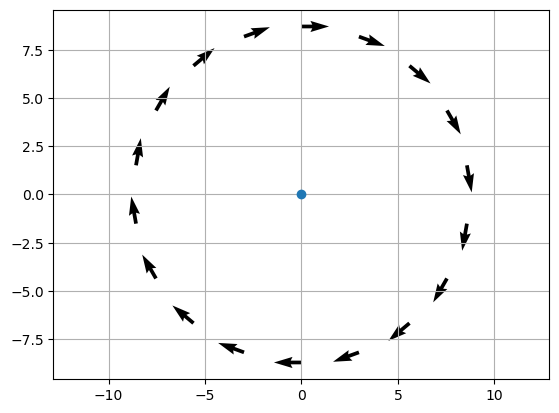

In [54]:
#plt.plot(p_m1s7[:,0], p_m1s7[:,1],'-o')
plt.quiver(p_m1s7[:,0], p_m1s7[:,1], v_m1s7[:,0], v_m1s7[:,1])
plt.plot(0,0,'o')
plt.axis('equal')
plt.grid();
#for Numerical testing configuration, we should see a circle.

#### we need to transform these from M1S7 CS to M1B1 CS.

In [82]:
#x_m1s1o = p_m1s7[0,:3]
x_m1b1o = np.array([0, 8818.625, 602.002])
R_m1b1 = np.array([[-1,0,0], [0, 0.9723, 0.2338], [0,0.2338, -0.9723]])
def T_m1b1(x):
    return R_m1b1@ (x-x_m1b1o)
def T_m1b1_vec(x):
    return T_m1b1(x) - T_m1b1(np.array([0,0,0]))

In [80]:
#this is a test vector from DOC-1118
x_tst1 = [4330.127, 2500, 9000] #x,y,z in M1S7
#x,y,z in M1B1 should be [−4330.127, −4179.865, −9642.620]
T_m1b1(x_tst1)

array([-4330.127    , -4180.1471551, -9642.6679804])

#### In M1B, we will start with a -x, -y, +Rz motion. That is my prediction. Let's check the math

In [91]:
print(v_m1s7.shape)
v_m1s7_tst = v_m1s7[9,:3] #for Numerical testing config, this is after 180 deg rotation
print(v_m1s7_tst)
print(T_m1b1(v_m1s7_tst))
print(T_m1b1_vec(v_m1s7_tst)) #for Numerical tsting config, the vector has been reversed in x

(18, 6)
[-1.52018178e-01 -1.86168575e-17  0.00000000e+00]
[ 1.52018178e-01 -8.71509716e+03 -1.47646798e+03]
[0.15201818 0.         0.        ]


In [92]:
print(v_m1s7.shape)
R_m1s7_tst = v_m1s7[9,3:] #for Numerical testing config, this is after 180 deg rotation
print(R_m1s7_tst)
print(T_m1b1(R_m1s7_tst))
print(T_m1b1_vec(R_m1s7_tst)) #for Numerical tsting config, the vector has been reversed in x

(18, 6)
[ 0.          0.         -0.01745329]
[    0.         -8715.10123568 -1476.45101056]
[ 0.         -0.00408058  0.01696984]


In [88]:
v_m1s7[9,3:] 

array([0., 0., 0.])

In [ ]:
make theta_B a variable
if theta_B = 0, check Rz transformation.
yes, in principle, even the order of Rx, Ry, Rz matters, but we are dealing with a simplified case where Rx = Ry = 0.
the rotation vector should follow R' = T R?